# Workflow Debugging

['c3sqrtx' 'c3x' 'c4x' 'ccx' 'ch' 'cp' 'crx' 'cry' 'crz' 'cswap' 'csx'
 'cu' 'cu1' 'cu3' 'cx' 'cy' 'cz' 'h' 'id' 'num_qubits' 'p' 'rc3x' 'rccx'
 'rx' 'rxx' 'ry' 'rz' 'rzz' 's' 'sdg' 'swap' 'sx' 'sxdg' 't' 'tdg' 'u'
 'u0' 'u1' 'u2' 'u3' 'x' 'y' 'z']
0.8833333333333333
len(y_predicted) 420
qaoa_indep_22.qasm_22  predicted:  1  should be:  0  diff:  1.1790865263496286
qpeexact_indep_23.qasm_23  predicted:  1  should be:  0  diff:  6.345146630337695e-11
qft_indep_21.qasm_21  predicted:  1  should be:  0  diff:  0.003743265293859821
qpeinexact_indep_13.qasm_13  predicted:  1  should be:  0  diff:  2.0020096668460496e-05
qft_indep_26.qasm_26  predicted:  1  should be:  0  diff:  0.02902811630523061
qft_indep_15.qasm_15  predicted:  1  should be:  0  diff:  0.0026185363292086095
su2random_indep_18.qasm_18  predicted:  5  should be:  0  diff:  0.24193811272799692
qft_indep_19.qasm_19  predicted:  1  should be:  0  diff:  0.053738390907941636
qftentangled_indep_17.qasm_17  predicted:  1  should

DecisionTreeClassifier(max_depth=5)

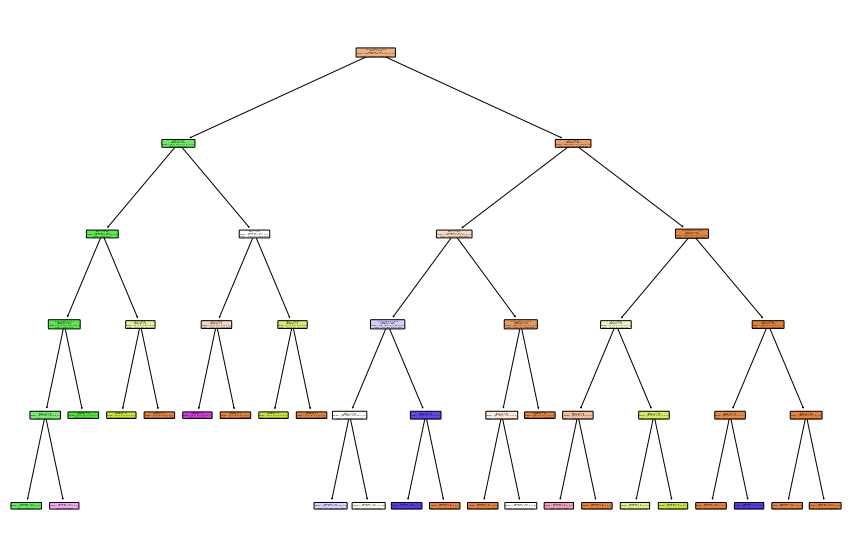

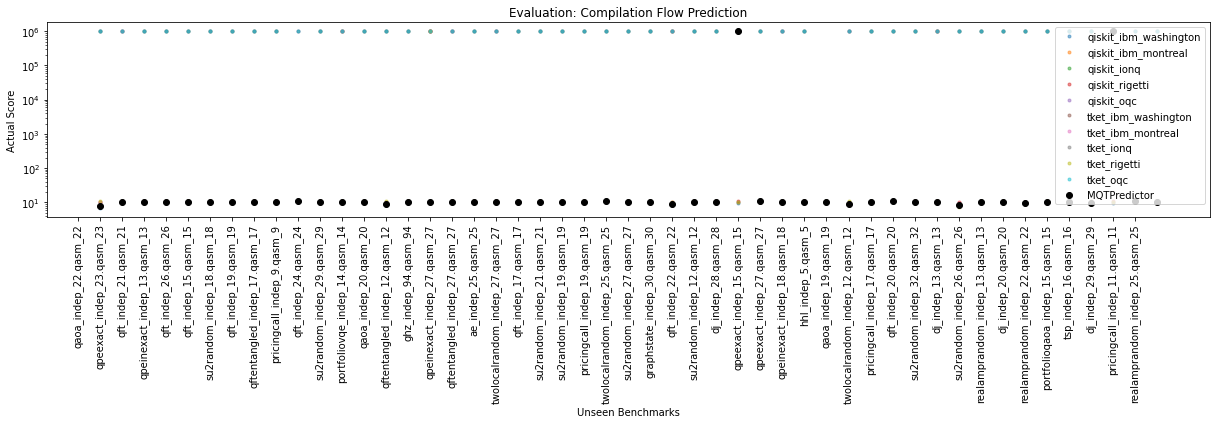

In [1]:
from predictor.driver import extract_training_data_from_json, train_neural_network
from predictor.src import utils
from predictor.driver import train_decision_tree_classifier

import numpy as np

from sklearn import preprocessing
from sklearn.model_selection import train_test_split


training_data, names_list, scores_list = extract_training_data_from_json("json_data_bigger_server.json", True)
#print(names_list)
X, y = zip(*training_data)
X = np.array(X)
y = np.array(y)

#non_zero_indices = []
#for i in range(len(X[0])):
#    if sum(X[:,i]) > 0:
#        non_zero_indices.append(i)
#X = X[:, non_zero_indices]

scaler = preprocessing.StandardScaler().fit(X)
#X = preprocessing.normalize(X, norm='l2')
#X = scaler.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

openqasm_gates_list = utils.get_openqasm_gates()
res = [openqasm_gates_list[i] for i in range(0, len(openqasm_gates_list))]
res.append("num_qubits")

features = np.sort(np.array(res))
#features = features[non_zero_indices]
print(features)
train_decision_tree_classifier(X,y, names_list, scores_list)

Metal device set to: Apple M1 Pro
Epoch 1/100


2022-05-04 17:02:00.899302: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-04 17:02:00.899412: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-05-04 17:02:00.977690: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


 8/31 [======>.......................] - ETA: 0s - loss: 17.9651 - accuracy: 0.3828    

2022-05-04 17:02:01.125389: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - 0s 7ms/step - loss: 6.2003 - accuracy: 0.6387
Epoch 2/100
31/31 [==============================] - 0s 6ms/step - loss: 1.7272 - accuracy: 0.7677
Epoch 3/100
31/31 [==============================] - 0s 6ms/step - loss: 0.8745 - accuracy: 0.7738
Epoch 4/100
31/31 [==============================] - 0s 6ms/step - loss: 0.9111 - accuracy: 0.7922
Epoch 5/100
31/31 [==============================] - 0s 6ms/step - loss: 0.6124 - accuracy: 0.8311
Epoch 6/100
31/31 [==============================] - 0s 6ms/step - loss: 0.9636 - accuracy: 0.8280
Epoch 7/100
31/31 [==============================] - 0s 6ms/step - loss: 0.8346 - accuracy: 0.8137
Epoch 8/100
31/31 [==============================] - 0s 6ms/step - loss: 0.7581 - accuracy: 0.8342
Epoch 9/100
31/31 [==============================] - 0s 6ms/step - loss: 0.5212 - accuracy: 0.8454
Epoch 10/100
31/31 [==============================] - 0s 6ms/step - loss: 0.5353 - accuracy: 0.8475
Epoch 11/100
31/31 [=

31/31 [==============================] - 0s 6ms/step - loss: 0.1827 - accuracy: 0.9232
Epoch 84/100
31/31 [==============================] - 0s 6ms/step - loss: 0.2095 - accuracy: 0.9089
Epoch 85/100
31/31 [==============================] - 0s 6ms/step - loss: 0.2287 - accuracy: 0.9017
Epoch 86/100
31/31 [==============================] - 0s 6ms/step - loss: 0.2122 - accuracy: 0.9007
Epoch 87/100
31/31 [==============================] - 0s 6ms/step - loss: 0.1940 - accuracy: 0.9099
Epoch 88/100
31/31 [==============================] - 0s 6ms/step - loss: 0.1806 - accuracy: 0.9232
Epoch 89/100
31/31 [==============================] - 0s 6ms/step - loss: 0.1906 - accuracy: 0.9110
Epoch 90/100
31/31 [==============================] - 0s 6ms/step - loss: 0.1786 - accuracy: 0.9222
Epoch 91/100
31/31 [==============================] - 0s 6ms/step - loss: 0.1758 - accuracy: 0.9243
Epoch 92/100
31/31 [==============================] - 0s 6ms/step - loss: 0.1889 - accuracy: 0.9120
Epoch 93/100


2022-05-04 17:02:20.066639: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Accuracy on training data: 0.938587486743927% 
 Error on training data: 0.061412513256073
Accuracy on test data: 0.9119048118591309% 
 Error on test data: 0.08809518814086914


2022-05-04 17:02:20.354535: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


0.9119047619047619
len(y_predicted) 420
qwalk-noancilla_indep_4.qasm_4  predicted:  8  should be:  0  diff:  0.8855153524363768
qaoa_indep_14.qasm_14  predicted:  0  should be:  1  diff:  0.9182986241059137
qpeexact_indep_28.qasm_28  predicted:  1  should be:  0  diff:  999989.65332902
qpeexact_indep_23.qasm_23  predicted:  1  should be:  0  diff:  6.345146630337695e-11
qft_indep_21.qasm_21  predicted:  1  should be:  0  diff:  0.003743265293859821
qpeinexact_indep_13.qasm_13  predicted:  1  should be:  0  diff:  2.0020096668460496e-05
qaoa_indep_13.qasm_13  predicted:  2  should be:  1  diff:  999994.4828806508
su2random_indep_18.qasm_18  predicted:  1  should be:  0  diff:  0.005542520474410395
qft_indep_19.qasm_19  predicted:  1  should be:  0  diff:  0.053738390907941636
qftentangled_indep_17.qasm_17  predicted:  1  should be:  0  diff:  0.022731331817018585
pricingcall_indep_9.qasm_9  predicted:  1  should be:  0  diff:  0.002793890591332726
portfoliovqe_indep_14.qasm_14  predicte

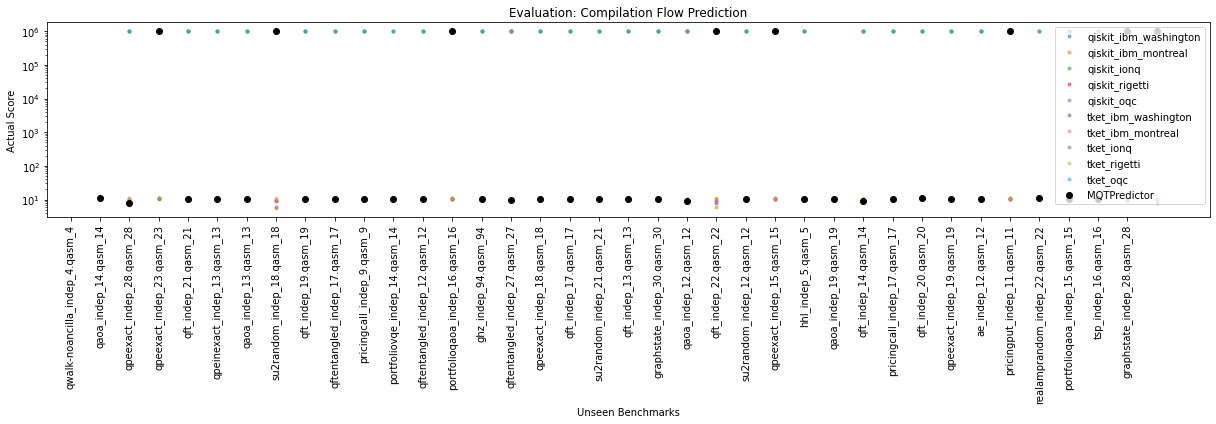

In [2]:
train_neural_network(X,y, names_list, scores_list)